# Zero-shot Image Classification with OpenAI CLIP and OpenVINO™

Zero-shot image classification is a computer vision task to classify images into one of several classes without any prior training or knowledge of the classes.

![zero-shot-pipeline](https://user-images.githubusercontent.com/29454499/207773481-d77cacf8-6cdc-4765-a31b-a1669476d620.png)

[**image source*](https://huggingface.co/tasks/zero-shot-image-classification)


Zero-shot learning resolves several challenges in image retrieval systems. For example, with the rapid growth of categories on the web, it is challenging to index images based on unseen categories. We can associate unseen categories to images with zero-shot learning by exploiting attributes to model's relationship between visual features and labels.
In this tutorial, we will use the [OpenAI CLIP](https://github.com/openai/CLIP) model to perform zero-shot image classification. The notebook contains the following steps:

1. Download the model.
2. Instantiate the PyTorch model.
3. Export the ONNX model and convert it to OpenVINO IR, using model conversion API.
4. Run CLIP with OpenVINO.

<a id="0"></a>
Table of content:
- [Instantiate model](#1)
- [Run PyTorch model inference](#2)
    - [Convert model to OpenVINO Intermediate Representation (IR) format.](#3)
- [Run OpenVINO model](#4)
    - [Select inference device](#5)
- [Next Steps](#6)


<a id="1"></a>
## Instantiate model [&#8657;](#0)

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on various (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.
CLIP uses a [ViT](https://arxiv.org/abs/2010.11929) like transformer to get visual features and a causal language model to get the text features. The text and visual features are then projected into a latent space with identical dimensions. The dot product between the projected image and text features is then used as a similarity score.

![clip](https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png)

[**image_source*](https://github.com/openai/CLIP/blob/main/README.md)

You can find more information about this model in the [research paper](https://arxiv.org/abs/2103.00020), [OpenAI blog](https://openai.com/blog/clip/), [model card](https://github.com/openai/CLIP/blob/main/model-card.md) and GitHub [repository](https://github.com/openai/CLIP).

In this notebook, we will use [openai/clip-vit-base-patch16](https://huggingface.co/openai/clip-vit-base-patch16), available via Hugging Face Transformers, but the same steps are applicable for other CLIP family models.

First, we need to create `CLIPModel` class object and initialize it with model configuration and weights, using `from_pretrained` method. The model will be automatically downloaded from Hugging Face Hub and cached for the next usage.
`CLIPProcessor` class is a wrapper for input data preprocessing. It includes both encoding the text using tokenizer and preparing the images.

In [1]:
from transformers import CLIPProcessor, CLIPModel

# load pre-trained model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
# load preprocessor for model input
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

<a id="2"></a>
## Run PyTorch model inference [&#8657;](#0)

To perform classification, define labels and load an image in RGB format. To give the model wider text context and improve guidance, we extend the labels description using the template "This is a photo of a".
Both the list of label descriptions and image should be passed through the processor to obtain a dictionary with input data in the model-specific format. The model predicts an image-text similarity score in raw logits format, which can be normalized to the `[0, 1]` range using the `softmax` function. Then, we select labels with the highest similarity score for the final result.

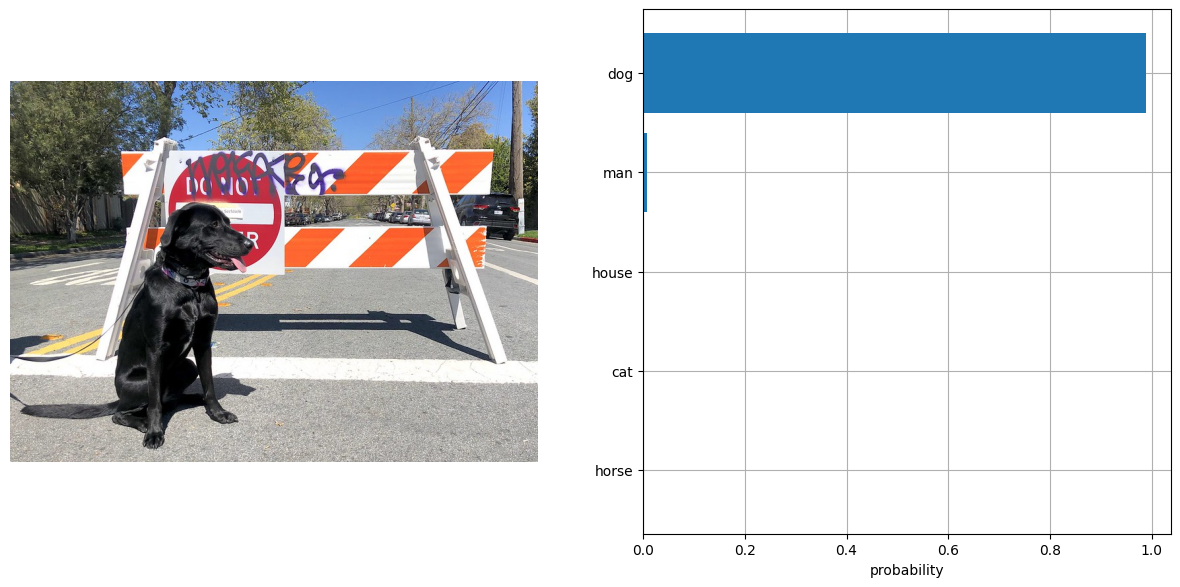

In [2]:
from PIL import Image
from visualize import visualize_result

image = Image.open('../data/image/coco.jpg')
input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'house', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], return_tensors="pt", padding=True)

results = model(**inputs)
logits_per_image = results['logits_per_image']  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1).detach().numpy()  # we can take the softmax to get the label probabilities
visualize_result(image, input_labels, probs[0])

<a id="3"></a>
### Convert model to OpenVINO Intermediate Representation (IR) format. [&#8657;](#0)

![conversion_path](https://user-images.githubusercontent.com/29454499/208048580-8264e54c-151c-43ef-9e25-1302cd0dd7a2.png)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via ONNX conversion. The `torch.onnx.export` function enables conversion of PyTorch models to ONNX format. It requires to provide initialized model object, example of inputs for tracing and path for saving result. The model contains operations which supported for ONNX tracing starting with opset 14, it is recommended to use it as `opset_version` parameter. Besides that, we need to have opportunity to provide descriptions various of length and images with different sizes, for preserving this capability after ONNX conversion, `dynamic_axes` parameter can be used. More information about PyTorch to ONNX exporting can be found in this [tutorial](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html) and [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). We will use `mo.convert_model` functionality to convert the ONNX model. The `mo.convert_model` Python function returns an OpenVINO model ready to load on the device and start making predictions. We can save it on disk for the next usage with `openvino.runtime.serialize`.


In [3]:
import torch

torch.onnx.export(
    model,  # model being run
    # model input in one of acceptable format: torch.Tensor (for single input), tuple or list of tensors for multiple inputs or dictionary with string keys and tensors as values.
    dict(inputs),
    "clip-vit-base-patch16.onnx",  # where to save the model
    opset_version=14,  # the ONNX version to export the model to
    input_names=["input_ids", "pixel_values", "attention_mask"],  # the model's input names
    output_names=["logits_per_image", "logits_per_text", "text_embeds", "image_embeds"],  # the model's output names
    dynamic_axes={  # variable length axes
        "input_ids": {0: "batch", 1: "sequence"},
        "pixel_values": {0: "batch", 1: "num_channels", 2: "height", 3: "width"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "logits_per_image": {0: "batch"},
        "logits_per_text": {0: "batch"},
        "text_embeds": {0: "batch"},
        "image_embeds": {0: "batch"}
    }
)

/home/adrian/repos/openvino_notebooks/recipes/intelligent_queue_management/venv/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/adrian/repos/openvino_notebooks/recipes/intelligent_queue_management/venv/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:324: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
/home/adrian/

In [4]:
from openvino.runtime import serialize
from openvino.tools import mo

ov_model = mo.convert_model('clip-vit-base-patch16.onnx', compress_to_fp16=True)
serialize(ov_model, 'clip-vit-base-patch16.xml')

<a id="4"></a>
## Run OpenVINO model [&#8657;](#0)

The steps for making predictions with the OpenVINO CLIP model are similar to the PyTorch model. Let us check the model result using the same input data from the example above with PyTorch.

In [5]:
from scipy.special import softmax
from openvino.runtime import Core

# create OpenVINO core object instance
core = Core()

<a id="5"></a>
### Select inference device [&#8657;](#0)

select device from dropdown list for running inference using OpenVINO

In [6]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

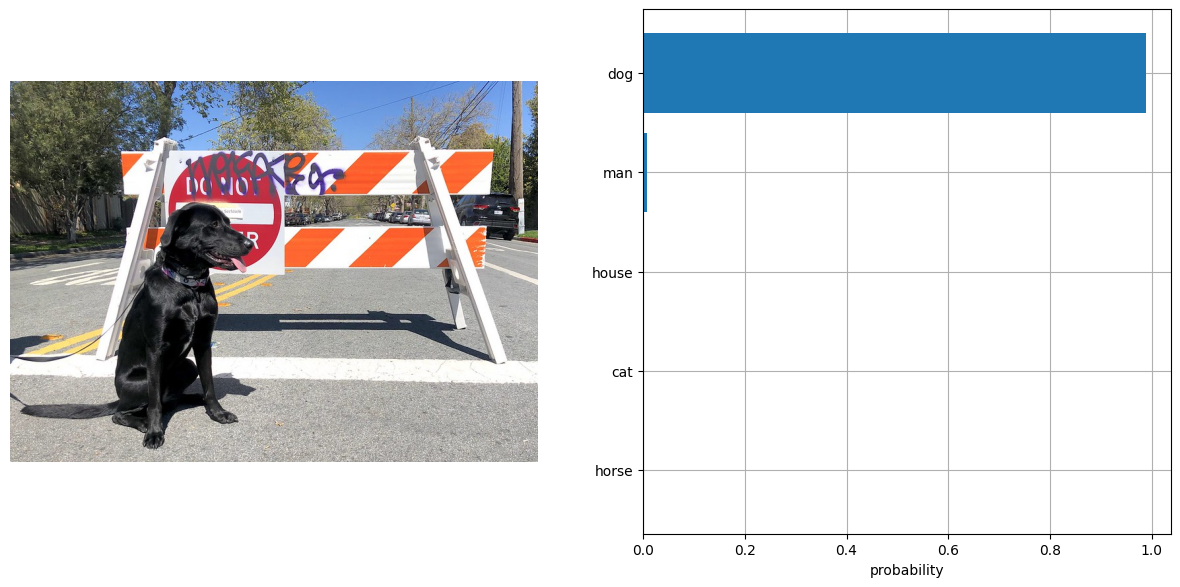

In [7]:
# compile model for loading on device
compiled_model = core.compile_model(ov_model, device.value)
# obtain output tensor for getting predictions
logits_per_image_out = compiled_model.output(0)
# run inference on preprocessed data and get image-text similarity score
ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
# perform softmax on score
probs = softmax(ov_logits_per_image, axis=1)
# visualize prediction
visualize_result(image, input_labels, probs[0])

Great! Looks like we got the same result.

Now, it is your turn! You can provide your own image and comma-separated list of labels for zero-shot classification.

Feel free to upload an image, using the file upload window and type label names into the text field, using comma as the separator (for example, `cat,dog,bird`)

In [8]:
import ipywidgets as widgets
style = {'description_width': 'initial'}

image_widget = widgets.FileUpload(
    accept='',
    multiple=False,
    description='Upload image',
    style=style
)

labels_widget = widgets.Textarea(
    value='cat,dog,bird',
    placeholder='Type something',
    description='Enter your classes separated by ,:',
    disabled=False,
    style=style
)
widgets.VBox(children=[image_widget, labels_widget])

Run the next cell to get the result for your submitted data:

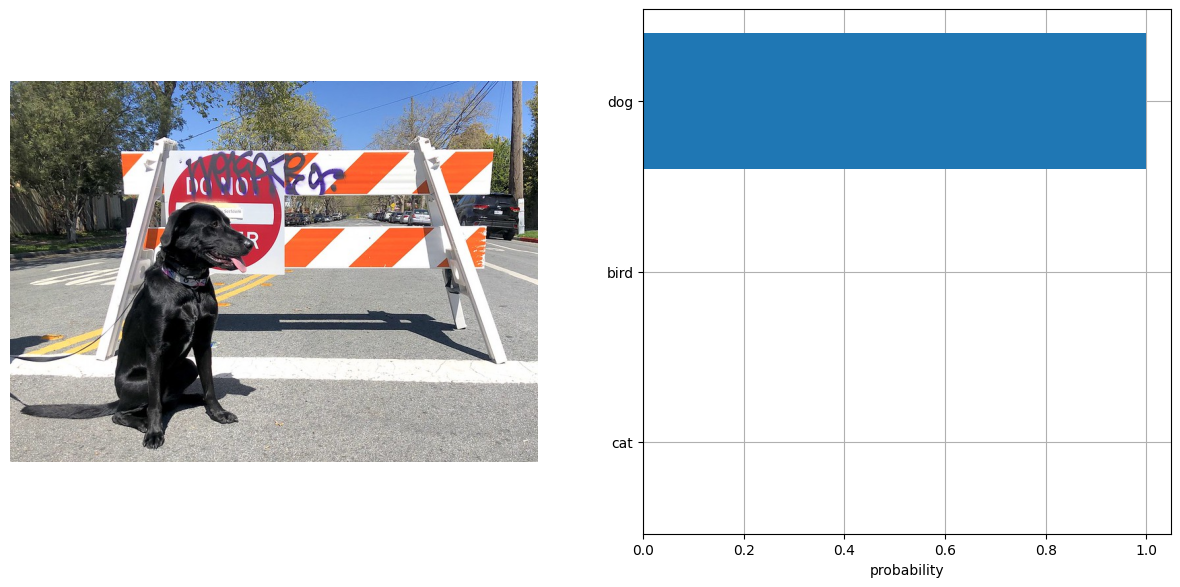

In [9]:
import io
# read uploaded image
image = Image.open(io.BytesIO(image_widget.value[-1]['content'])) if image_widget.value else image
# obtain list of labels
labels = labels_widget.value.split(',')
# convert labels to text description
text_descriptions = [f"This is a photo of a {label}" for label in labels]

# preprocess input
inputs = processor(text=text_descriptions, images=[image], return_tensors="np", padding=True)
# run inference
ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
# perform softmax on score
probs = softmax(ov_logits_per_image, axis=1)
# visualize prediction
visualize_result(image, labels, probs[0])

<a id="6"></a>
## Next Steps [&#8657;](#0)

Open the [228-clip-zero-shot-quantize](228-clip-zero-shot-quantize.ipynb) notebook to quantize the IR model with the Post-training Quantization API of NNCF and compare `FP16` and `INT8` models.